## **Importing libraries**

In [2]:
import torch
import torchvision
import cv2
import os
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights

## **Removing annotation file with unwanted**

In [15]:
import os
from PIL import Image

annotation_dir = r"C:\Users\Ayon Dandapath\Videos\annotation box frames\label"
images_dir = r"C:\Users\Ayon Dandapath\Videos\annotation box frames\images"

annotations = os.listdir(annotation_dir)

for annotation in annotations:
    annotation_file = os.path.join(annotation_dir, annotation)
    image_file_name = annotation[:-4] + '.jpg'

    img = Image.open(os.path.join(images_dir, image_file_name))
    width, height = img.size

    with open(annotation_file, "r") as f:
        for line in f:
            data = line.strip().split()
            class_index = int(data[0])  # Class index
            x_center = float(data[1]) * width
            y_center = float(data[2]) * height
            box_width = float(data[3]) * width
            box_height = float(data[4]) * height

            # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
            xmin = x_center - box_width / 2
            ymin = y_center - box_height / 2
            xmax = x_center + box_width / 2
            ymax = y_center + box_height / 2



## **Create customdataset class**

In [16]:
class CustomDataset():
    def __init__(self, image_dir, annotations, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get annotation file name
        annotation = self.annotations[idx]
        # Get image path
        img_path = os.path.join(self.image_dir, annotation[:-4] + '.jpg')

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Convert image channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        height, width, _ = image.shape

        # Parse the annotation file
        annotation_file = os.path.join(self.annotations_dir, annotation)
        boxes = []
        labels = []

        # Open annotation file
        with open(annotation_file, "r") as f:
            for line in f:
                # Split data
                data = line.strip().split()
                class_index = int(data[0])  # Class index
                x_center = float(data[1]) * width
                y_center = float(data[2]) * height
                box_width = float(data[3]) * width
                box_height = float(data[4]) * height

                # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_index + 1))

        # Convert to PyTorch tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Create target dictionary
        target = {"boxes": boxes, "labels": labels}

        return image, target



## **Load Pretrained Model and Modify for Custom Classes**

In [5]:
import torch
import torchvision
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils

def create_model(num_classes=2, size=300):
    model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)

    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()

    # Replace the classification head for 1 class (pothole) + background
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )

    # Adjust transform sizes
    model.transform.min_size = (size,)
    model.transform.max_size = size

    return model

model = create_model(num_classes=2, size=300)
print(model)


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

## **Creating the Dataloader**

In [21]:
# Step 4: Dataset and DataLoader
import os
from torchvision import transforms
from torch.utils.data import DataLoader
## TRAIN DATALOADER
train_image_dir = r"C:\Users\Ayon Dandapath\Videos\annotation box frames\images"
train_annotation_dir = r"C:\Users\Ayon Dandapath\Videos\annotation box frames\label"
train_annotations = os.listdir(train_annotation_dir)

train_dataset = CustomDataset(train_image_dir, train_annotations, train_annotation_dir, transform=transforms.ToTensor())
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, collate_fn=lambda x: tuple(zip(*x)))
print(len(train_data_loader))

208


## **Setting LR OPTIM**

In [22]:
# Step 5: Training Setup
import torch
import torchvision
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 50


# Epoch 1, LR: 0.001000
# Epoch 2, LR: 0.001000
# Epoch 3, LR: 0.001000
# Epoch 4, LR: 0.001 * 0.1 ==   0.000100
# Epoch 5, LR: 0.000100
# Epoch 6, LR: 0.000100
# Epoch 7, LR: 0.0001 * 0.1 == 0.000010

## **Checking Dataloader**

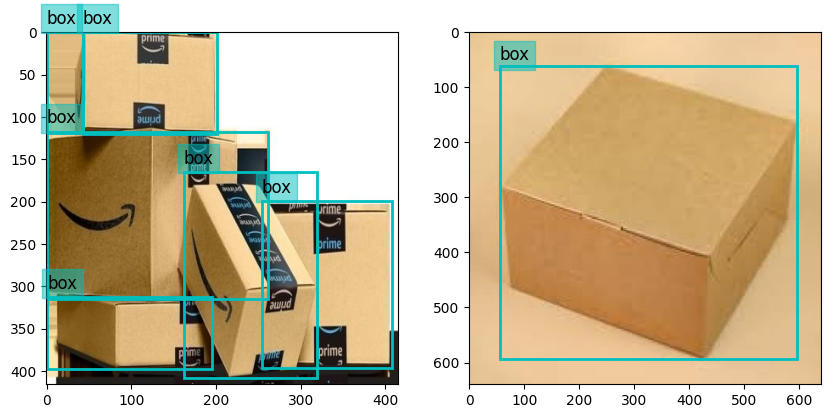

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

# Get a batch of images and targets from the data loader
data_loader_iter = iter(train_data_loader)
images, targets = next(data_loader_iter)


class_names = ['bg', 'box']
color_sample = ['c','m','y']

# Plot the images with bounding boxes
for idx in range(2):
    image = images[idx].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization
    target = targets[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    ax[idx].imshow(image)

    # Add bounding boxes to the image
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor=color_sample[label-1],
            facecolor="none",
        )
        ax[idx].add_patch(rect)
        ax[idx].text(
            xmin,
            ymin - 10,
            f"{class_names[label]}",
            color="k",
            fontsize=12,
            bbox=dict(facecolor=color_sample[label-1], alpha=0.5, edgecolor=color_sample[label-1]),
        )

# Display the image with bounding boxes
plt.show()

In [ ]:
def filter_invalid_boxes(targets):
    valid_targets = []
    for target in targets:
        boxes = target['boxes']
        labels = target['labels']

        # Calculate width and height
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]

        # Keep only boxes with positive width and height
        valid_mask = (widths > 0) & (heights > 0)
        boxes = boxes[valid_mask]
        labels = labels[valid_mask]

        valid_targets.append({'boxes': boxes, 'labels': labels})
    return valid_targets

# ===============================
# Training Loop with Box Checks
# ===============================
num_epochs = 50

for epoch in range(num_epochs):
    print(f'Starting the training of Epoch_{epoch+1}.....')
    print('Training...')

    model.train()
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs} training')

    for images, targets in train_data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Filter invalid boxes (zero area)
        targets = filter_invalid_boxes(targets)

        #  Skip if any image has no valid boxes
        if any(len(t["boxes"]) == 0 for t in targets):
            continue

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_running_loss += losses.item()

    scheduler.step()
    print(f"Train_Loss: {train_running_loss/len(train_dataset):.4f}")
    print('\n')


Starting the training of Epoch_1.....
Training...
Epoch 1/50 training
Train_Loss: 0.3018


Starting the training of Epoch_2.....
Training...
Epoch 2/50 training
Train_Loss: 0.1652


Starting the training of Epoch_3.....
Training...
Epoch 3/50 training
Train_Loss: 0.1396


Starting the training of Epoch_4.....
Training...
Epoch 4/50 training
Train_Loss: 0.1122


Starting the training of Epoch_5.....
Training...
Epoch 5/50 training
Train_Loss: 0.1095


Starting the training of Epoch_6.....
Training...
Epoch 6/50 training
Train_Loss: 0.1060


Starting the training of Epoch_7.....
Training...
Epoch 7/50 training


In [27]:
# Step 7: Save Trained Model
torch.save(model.state_dict(), "count_box_detection.pth")

## **Testing the image**

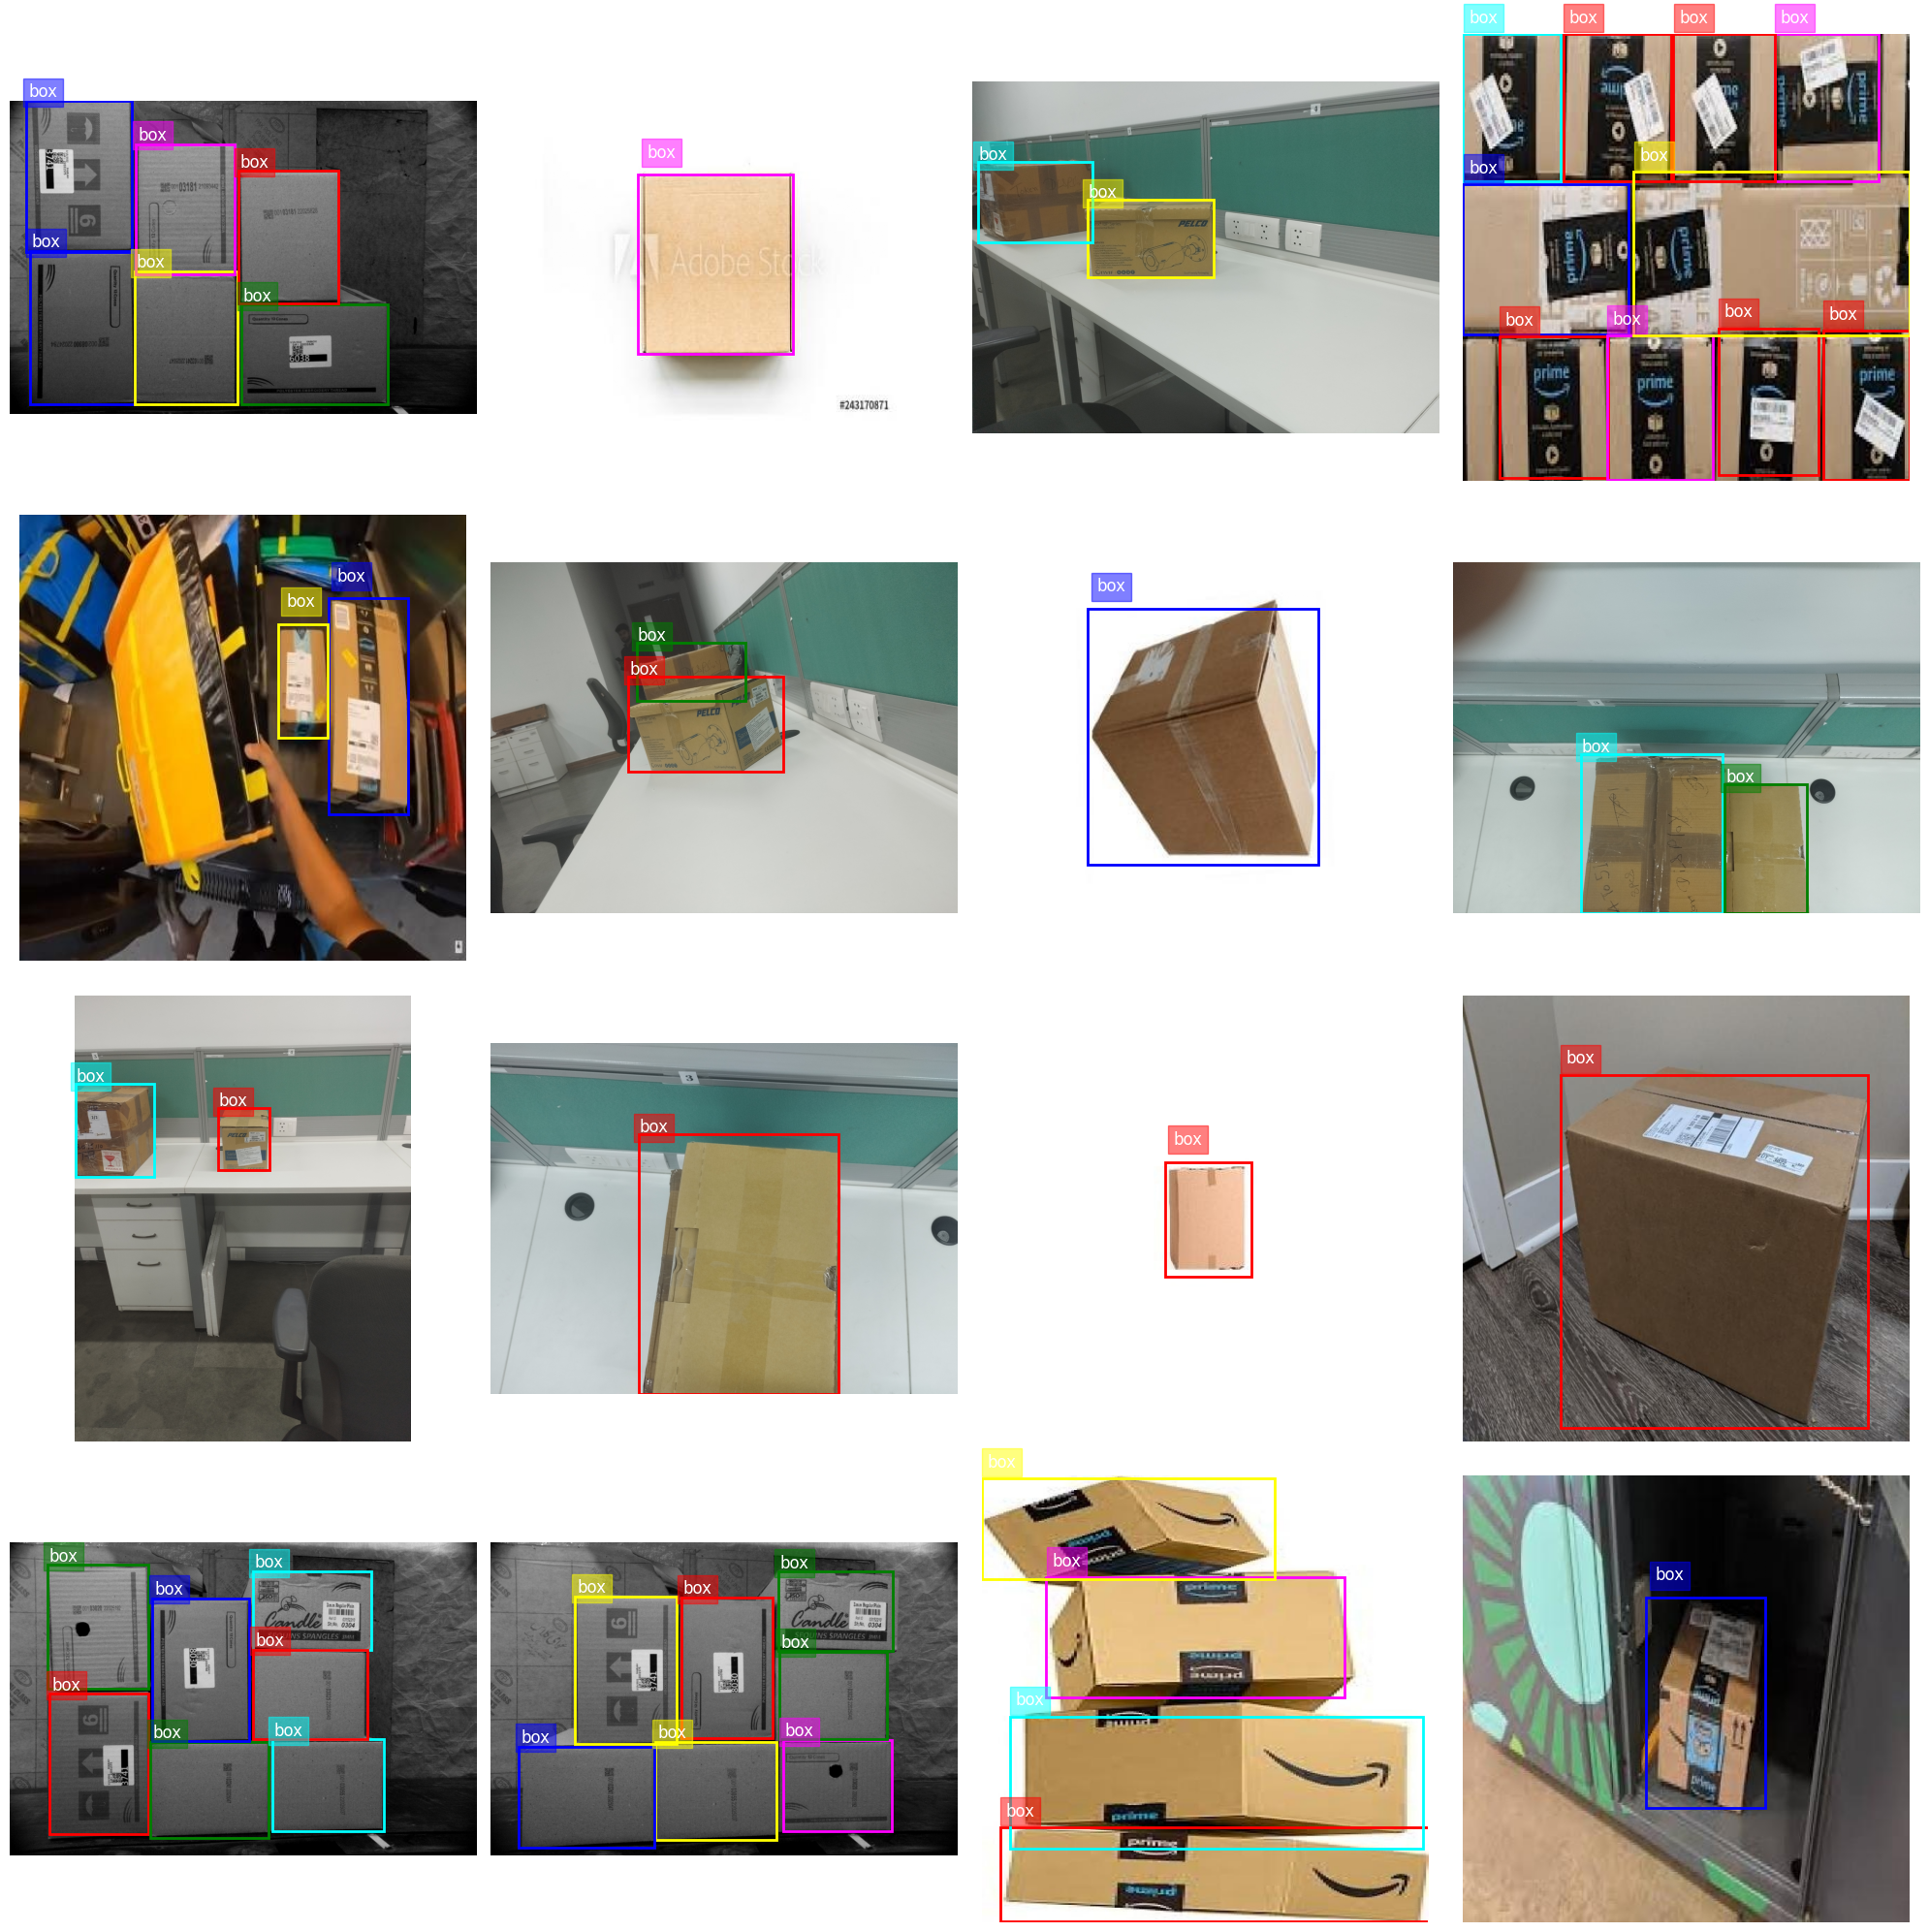

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms

# ================ Setup ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (ensure you have defined create_model elsewhere)
model = create_model(num_classes=2, size=300)
model.load_state_dict(torch.load("count_box_detection.pth", map_location=torch.device('cpu')))
model.eval()
model.to(device)

transform = transforms.ToTensor()
class_names = ['bg', 'box']
test_dir = r"C:\Users\Ayon Dandapath\Desktop\summer intenship certificates and documents of college\asadel technology documents for college\custom model from  scratch of object detection\annotation box frames\images"
test_list_file = os.listdir(test_dir)
color_sample = ['c', 'm', 'y']

# Create output directory if it doesn't exist
os.makedirs("img", exist_ok=True)

# ================ Visualization ================
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.ravel()

for idx in range(16):  # 4x4 = 16 subplots
    img_path = os.path.join(test_dir, random.choice(test_list_file))
    image = Image.open(img_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    # Prepare image for display
    image_np = image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    ax[idx].imshow(image_np)
    ax[idx].axis('off')

    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            color = random.choice(['red', 'green', 'blue', 'yellow', 'cyan', 'magenta'])

            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2,
                                     edgecolor=color, facecolor="none")
            ax[idx].add_patch(rect)
            ax[idx].text(xmin + 8, ymin - 16, f"{class_names[label]}", color='w',
                         fontsize=12, bbox=dict(facecolor=color, alpha=0.5, edgecolor=color))

    # Save individual subplot
    extent = ax[idx].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"img/subplot_001vdd{idx}.png", bbox_inches=extent, dpi=300)

plt.tight_layout()
plt.show()

## **Testing the vedio**

In [ ]:
import cv2
import torch
import torchvision
import numpy as np
from torchvision.transforms import transforms
import random
import os

# ======== Setup ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (ensure create_model is defined)
model = create_model(num_classes=2, size=300)
model.load_state_dict(torch.load("count_box_detection.pth", map_location='cpu'))
model.eval()
model.to(device)

transform = transforms.ToTensor()
class_names = ['bg', 'box']

# ======== Video Setup ========
video_path = r"c:\Users\Ayon Dandapath\Downloads\WhatsApp Video 2025-06-18 at 1.07.46 PM_out.mp4"  # Your input video
output_path = "object_detected_video.mp4"  # Output video path

cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define VideoWriter for saving output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# ======== Detection Loop ========
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR to RGB and to PIL image
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.8:
            xmin, ymin, xmax, ymax = map(int, box)
            color = tuple([random.randint(0, 255) for _ in range(3)])

            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
            label_text = f"{class_names[label]}: {score:.2f}"
            cv2.putText(frame, label_text, (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(frame)

   

# ======== Cleanup ========
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video saved to:", output_path)


Video saved to: object_detected_video.mp4
